# **DeepBedMap**

Predicting the bed elevation of Antarctica using a Super Resolution Deep Neural Network.

In [1]:
import math
import os
import typing

os.environ["CUDA_VISIBLE_DEVICES"] = ""

import xarray as xr
import salem

import comet_ml
import cupy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import numpy as np
import pandas as pd
import pygmt as gmt
import quilt
import rasterio
import skimage

import chainer

from features.environment import _load_ipynb_modules

data_prep = _load_ipynb_modules("data_prep.ipynb")

## Get bounding box of area we want to predict on

In [2]:
def get_image_with_bounds(filepaths: list, indexers: dict = None) -> xr.DataArray:
    """
    Retrieve raster image in xarray.DataArray format patched
    with projected coordinate bounds as (xmin, ymin, xmax, ymax)

    Note that if more than one filepath is passed in,
    the output groundtruth image array will not be valid
    (see https://github.com/pydata/xarray/issues/2159),
    but the window_bound extents will be correct
    """

    with xr.open_mfdataset(paths=filepaths, concat_dim=None) as dataset:
        # Retrieve dataarray from NetCDF datasets
        dataarray = dataset.z.isel(indexers=indexers)

    # Patch projection information into xarray grid
    dataarray.attrs["pyproj_srs"] = "epsg:3031"
    sgrid = dataarray.salem.grid.corner_grid
    assert sgrid.origin == "lower-left"  # should be "lower-left", not "upper-left"

    # Patch bounding box extent into xarray grid
    if len(filepaths) == 1:
        left, right, bottom, top = sgrid.extent
    elif len(filepaths) > 1:
        print("WARN: using multiple inputs, output groundtruth image may look funny")
        x_offset, y_offset = sgrid.dx / 2, sgrid.dy / 2
        left, right = (
            float(dataarray.x[0] - x_offset),
            float(dataarray.x[-1] + x_offset),
        )
        assert sgrid.x0 == left
        bottom, top = (
            float(dataarray.y[0] - y_offset),
            float(dataarray.y[-1] + y_offset),
        )
        assert sgrid.y0 == bottom  # dataarray.y.min()-y_offset

    # check that y-axis and x-axis lengths are divisible by 4
    try:
        shape = int((top - bottom) / sgrid.dy), int((right - left) / sgrid.dx)
        assert all(i % 4 == 0 for i in shape)
    except AssertionError:
        print(f"WARN: Image shape {shape} should be divisible by 4 for DeepBedMap")
    finally:
        dataarray.attrs["bounds"] = [left, bottom, right, top]

    return dataarray

In [3]:
test_filepaths = ["highres/2007tx", "highres/2010tr", "highres/istarxx"]
groundtruth = get_image_with_bounds(
    filepaths=[f"{t}.nc" for t in test_filepaths],
    indexers={"y": slice(0, -1), "x": slice(0, -1)},
)

WARN: using multiple inputs, output groundtruth image may look funny


## Get neural network input datasets for our area of interest

In [4]:
def get_deepbedmap_model_inputs(
    window_bound: rasterio.coords.BoundingBox, padding=1000
) -> (np.ndarray, np.ndarray, np.ndarray):
    """
    Outputs one large tile for each of
    BEDMAP2, REMA and MEASURES Ice Flow Velocity
    according to a given window_bound in the form of
    (xmin, ymin, xmax, ymax).
    """
    data_prep = _load_ipynb_modules("data_prep.ipynb")

    X_tile = data_prep.selective_tile(
        filepath="lowres/bedmap2_bed.tif",
        window_bounds=[[*window_bound]],
        # out_shape=None,  # 1000m spatial resolution
        padding=padding,
    )
    W2_tile = data_prep.selective_tile(
        filepath="misc/MEaSUREs_IceFlowSpeed_450m.tif",
        window_bounds=[[*window_bound]],
        out_shape=(2 * X_tile.shape[2], 2 * X_tile.shape[3]),  # 500m spatial resolution
        padding=padding,
        gapfill_raster_filepath="misc/lisa750_2013182_2017120_0000_0400_vv_v1_myr.tif",
    )
    W1_tile = data_prep.selective_tile(
        filepath="misc/REMA_100m_dem.tif",
        window_bounds=[[*window_bound]],
        # out_shape=(5 * W2_tile.shape[2], 5 * W2_tile.shape[3]),  # 100m spatial resolution
        padding=padding,
        gapfill_raster_filepath="misc/REMA_200m_dem_filled.tif",
    )

    return X_tile, W1_tile, W2_tile

In [5]:
def plot_3d_view(
    img: np.ndarray,
    ax: matplotlib.axes._subplots.Axes,
    elev: int = 60,
    azim: int = 330,
    cm_norm: matplotlib.colors.Normalize = None,
    title: str = None,
):
    # Get x, y, z data, assuming image in NCHW format
    image = img[0, :, :, :]
    xx, yy = np.mgrid[0 : image.shape[1], 0 : image.shape[2]]
    zz = image[0, :, :]

    # Make the 3D plot
    ax.view_init(elev=elev, azim=azim)
    ax.plot_surface(xx, yy, zz, cmap="BrBG", norm=cm_norm)
    ax.set_title(label=f"{title}\n", fontsize=22)

    return ax

In [6]:
X_tile, W1_tile, W2_tile = get_deepbedmap_model_inputs(window_bound=groundtruth.bounds)
print(X_tile.shape, W1_tile.shape, W2_tile.shape)

# Build quilt package for datasets covering our test region
reupload = False
if reupload == True:
    quilt.build(package="weiji14/deepbedmap/model/test/W1_tile", path=W1_tile)
    quilt.build(package="weiji14/deepbedmap/model/test/W2_tile", path=W2_tile)
    quilt.build(package="weiji14/deepbedmap/model/test/X_tile", path=X_tile)
    quilt.push(package="weiji14/deepbedmap/model/test", is_public=True)

Tiling: lowres/bedmap2_bed.tif ... done!
Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif ... done!
Tiling: misc/REMA_100m_dem.tif ... done!
(1, 1, 160, 96) (1, 1, 1602, 960) (1, 1, 320, 192)


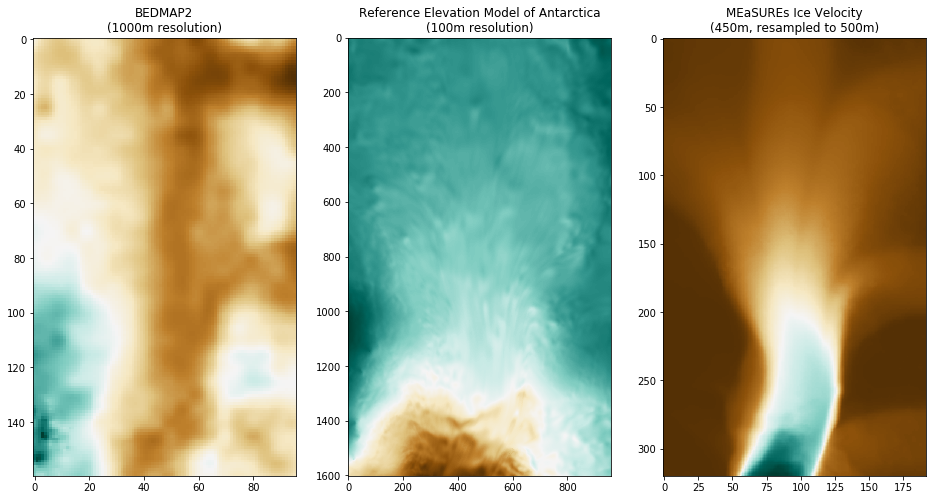

In [7]:
fig, axarr = plt.subplots(nrows=1, ncols=3, squeeze=False, figsize=(16, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2\n(1000m resolution)")
axarr[0, 1].imshow(W1_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Reference Elevation Model of Antarctica\n(100m resolution)")
axarr[0, 2].imshow(W2_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 2].set_title("MEaSUREs Ice Velocity\n(450m, resampled to 500m)")
plt.show()

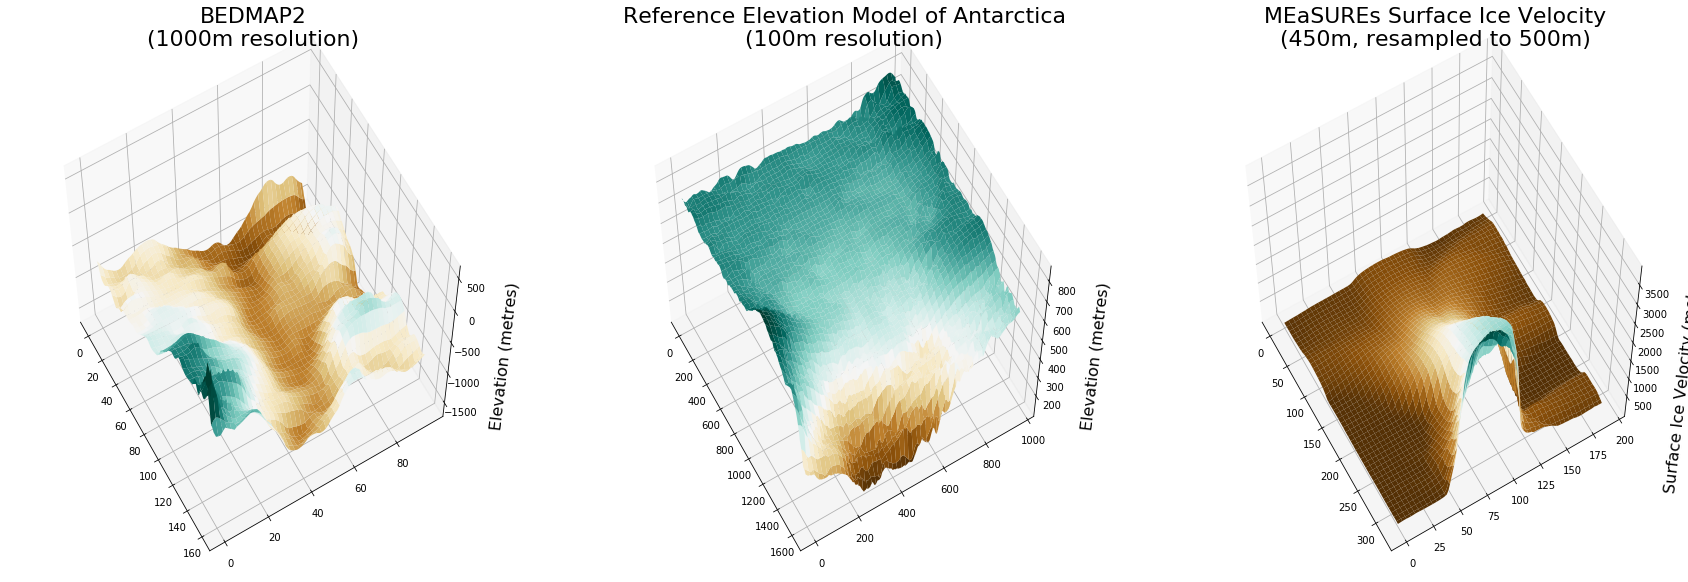

In [8]:
fig = plt.figure(figsize=plt.figaspect(1 / 3) * 2.5)

ax = fig.add_subplot(1, 3, 1, projection="3d")
ax = plot_3d_view(img=X_tile, ax=ax, title="BEDMAP2\n(1000m resolution)")
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

ax = fig.add_subplot(1, 3, 2, projection="3d")
ax = plot_3d_view(
    img=W1_tile,
    ax=ax,
    title="Reference Elevation Model of Antarctica\n(100m resolution)",
)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

ax = fig.add_subplot(1, 3, 3, projection="3d")
ax = plot_3d_view(
    img=W2_tile, ax=ax, title="MEaSUREs Surface Ice Velocity\n(450m, resampled to 500m)"
)
ax.set_zlabel("\n\nSurface Ice Velocity (metres/year)", fontsize=16)

plt.show()

## Create custom neural network for our area of interest

Fully convolutional networks rock!!
Since we have a fully convolutional model architecture,
we can change the shape of the inputs/outputs,
but use the same trained weights!
That way we can predict directly on an arbitrarily sized window.

In [9]:
def load_trained_model(
    model=None,
    model_weights_path: str = "model/weights/srgan_generator_model_weights.npz",
):
    """
    Builds the Generator component of the DeepBedMap neural network.
    Also loads trained parameter weights into the model from a .npz file.
    """
    srgan_train = _load_ipynb_modules("srgan_train.ipynb")

    if model is None:
        model = srgan_train.GeneratorModel(
            # num_residual_blocks=12,
            # residual_scaling=0.4,
        )

    # Load trained neural network weights into model
    chainer.serializers.load_npz(file=model_weights_path, obj=model)

    return model

## Make prediction

In [10]:
model = load_trained_model()

In [11]:
# Prediction on small area
Y_hat = model.forward(x=X_tile, w1=W1_tile, w2=W2_tile).array

## Load other interpolated grids for comparison

- Bicubic interpolated BEDMAP2
- Synthetic High Resolution Grid from [Graham et al.](https://doi.org/10.5194/essd-9-267-2017)

In [12]:
cubicbedmap2 = skimage.transform.rescale(
    image=X_tile[0, 0, 1:-1, 1:-1].astype(np.int32),
    scale=4,  # 4x upscaling
    order=3,  # cubic interpolation
    mode="reflect",
    anti_aliasing=True,
    multichannel=False,
    preserve_range=True,
)
cubicbedmap2 = np.expand_dims(np.expand_dims(cubicbedmap2, axis=0), axis=0)
print(cubicbedmap2.shape, Y_hat.shape)
assert cubicbedmap2.shape == Y_hat.shape

(1, 1, 632, 376) (1, 1, 632, 376)


In [13]:
S_tile = data_prep.selective_tile(
    filepath="model/hres.tif", window_bounds=[[*groundtruth.bounds]]
)

Tiling: model/hres.tif ... done!


## Plot results

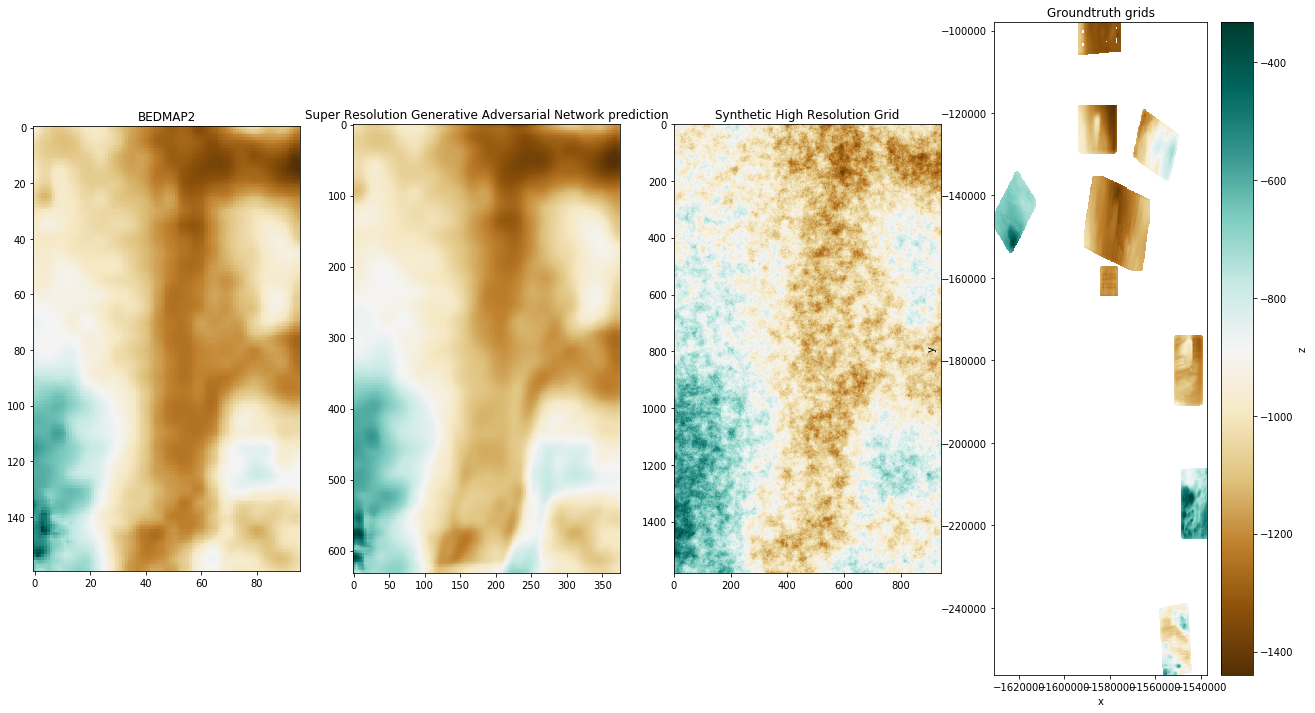

In [14]:
fig, axarr = plt.subplots(nrows=1, ncols=4, squeeze=False, figsize=(22, 12))
axarr[0, 0].imshow(X_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 0].set_title("BEDMAP2")
axarr[0, 1].imshow(Y_hat[0, 0, :, :], cmap="BrBG")
axarr[0, 1].set_title("Super Resolution Generative Adversarial Network prediction")
axarr[0, 2].imshow(S_tile[0, 0, :, :], cmap="BrBG")
axarr[0, 2].set_title("Synthetic High Resolution Grid")
groundtruth.plot(ax=axarr[0, 3], cmap="BrBG")
axarr[0, 3].set_title("Groundtruth grids")
plt.show()

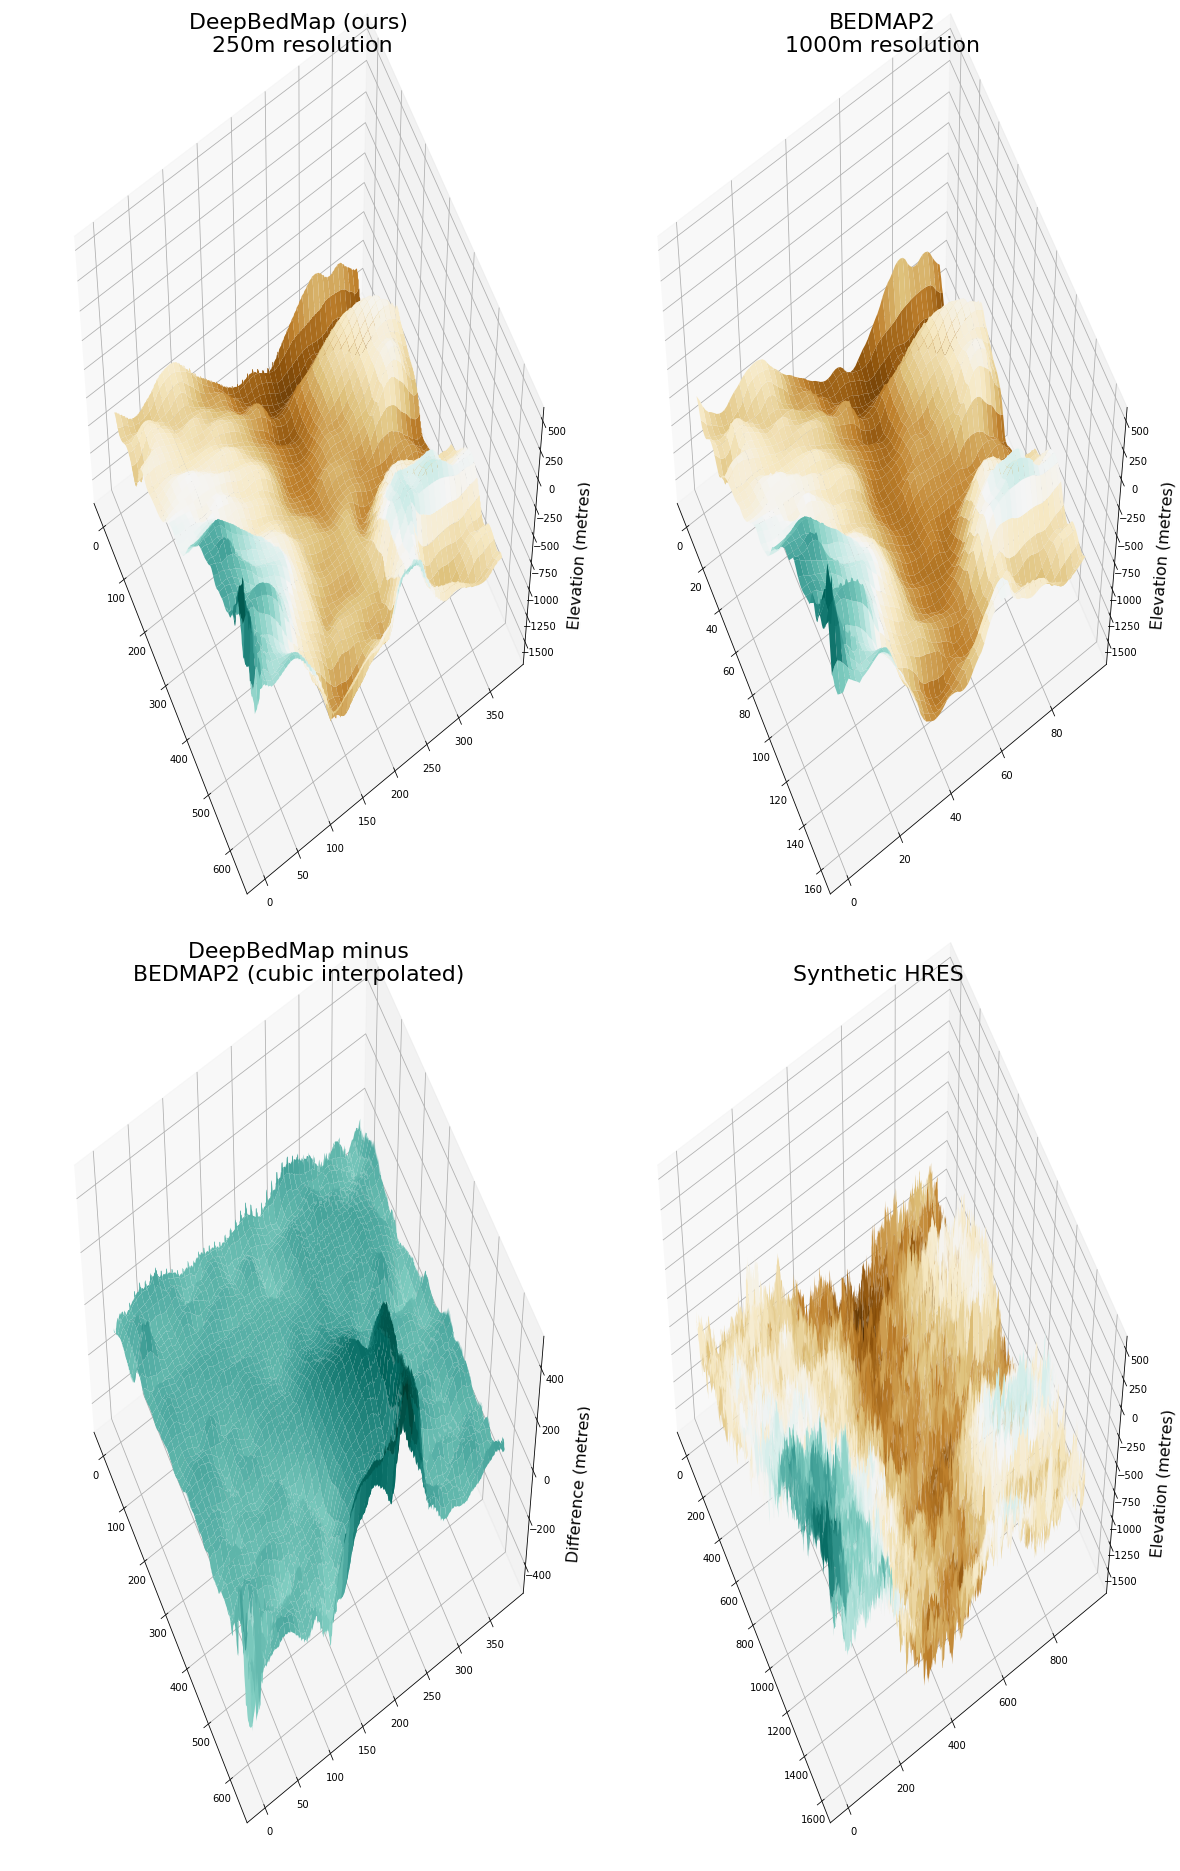

In [15]:
fig = plt.figure(figsize=plt.figaspect(12 / 9) * 4.5)  # (height/width)*scaling

zmin, zmax = (Y_hat.min(), Y_hat.max())
norm_Z = matplotlib.cm.colors.Normalize(vmin=zmin, vmax=zmax)

# DeepBedMap
ax = fig.add_subplot(2, 2, 1, projection="3d")
ax = plot_3d_view(
    img=Y_hat, ax=ax, cm_norm=norm_Z, title="DeepBedMap (ours)\n 250m resolution"
)
ax.set_zlim(bottom=zmin, top=zmax)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

# BEDMAP2
ax = fig.add_subplot(2, 2, 2, projection="3d")
ax = plot_3d_view(img=X_tile, ax=ax, cm_norm=norm_Z, title="BEDMAP2\n1000m resolution")
ax.set_zlim(bottom=zmin, top=zmax)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

# DeepBedMap - BEDMAP2
ax = fig.add_subplot(2, 2, 3, projection="3d")
ax = plot_3d_view(
    img=Y_hat - cubicbedmap2,
    ax=ax,
    cm_norm=norm_Z,
    title="DeepBedMap minus\nBEDMAP2 (cubic interpolated)",
)
ax.set_zlim(bottom=-500, top=500)
ax.set_zlabel("\n\nDifference (metres)", fontsize=16)

# Synthetic
ax = fig.add_subplot(2, 2, 4, projection="3d")
ax = plot_3d_view(img=S_tile, ax=ax, cm_norm=norm_Z, title="Synthetic HRES ")
ax.set_zlim(bottom=zmin, top=zmax)
ax.set_zlabel("\n\nElevation (metres)", fontsize=16)

plt.subplots_adjust(wspace=0.0001, hspace=0.0001, left=0.0, right=0.9, top=1.2)
# plt.savefig(fname="esrgan_prediction.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Save Bicubic BEDMAP2 and ESRGAN DeepBedMap to a grid file

In [16]:
def save_array_to_grid(
    window_bound: tuple, array: np.ndarray, outfilepath: str, dtype: str = None
):
    """
    Saves a numpy array to geotiff and netcdf format.
    Appends ".tif" and ".nc" file extension to the outfilepath
    for geotiff and netcdf outputs respectively.
    """

    assert array.ndim == 4
    assert array.shape[1] == 1  # check that there is only one channel

    transform = rasterio.transform.from_bounds(
        *window_bound, height=array.shape[2], width=array.shape[3]
    )

    # Save array as a GeoTiff first
    with rasterio.open(
        f"{outfilepath}.tif",
        mode="w",
        driver="GTiff",
        height=array.shape[2],
        width=array.shape[3],
        count=1,
        crs="EPSG:3031",
        transform=transform,
        dtype=array.dtype if dtype is None else dtype,
        nodata=-2000,
    ) as new_geotiff:
        new_geotiff.write(array[0, 0, :, :], 1)

    # Convert deepbedmap3 and cubicbedmap2 from geotiff to netcdf format
    xr.open_rasterio(f"{outfilepath}.tif").to_netcdf(f"{outfilepath}.nc")

In [17]:
# Save BEDMAP3 to GeoTiff and NetCDF format
save_array_to_grid(
    window_bound=groundtruth.bounds, array=Y_hat, outfilepath="model/deepbedmap3"
)

In [18]:
# Save Bicubic Resampled BEDMAP2 to GeoTiff and NetCDF format
save_array_to_grid(
    window_bound=groundtruth.bounds, array=cubicbedmap2, outfilepath="model/cubicbedmap"
)

In [19]:
synthetic = skimage.transform.rescale(
    image=S_tile[0, 0, :, :].astype(np.int32),
    scale=1 / 2.5,  # 2.5 downscaling
    order=1,  # billinear interpolation
    mode="reflect",
    anti_aliasing=True,
    multichannel=False,
    preserve_range=True,
)
save_array_to_grid(
    window_bound=groundtruth.bounds,
    array=np.expand_dims(np.expand_dims(synthetic, axis=0), axis=0),
    outfilepath="model/synthetichr",
)

# Crossover analysis

We use [grdtrack](https://gmt.soest.hawaii.edu/doc/latest/grdtrack) to sample our grid along the survey tracks.

The survey tracks are basically geographic xy points flown by a plane.
The three grids are all 250m spatial resolution, and they are:

- Groundtruth grid (interpolated from our groundtruth points using [surface](https://gmt.soest.hawaii.edu/doc/latest/surface.html))
- DeepBedMap3 grid (predicted from our [Super Resolution Generative Adversarial Network model](/srgan_train.ipynb))
- CubicBedMap grid (interpolated from BEDMAP2 using a [bicubic spline algorithm](http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.rescale))
- Synthetic High Res grid (created by [Graham et al.](https://doi.org/10.5194/essd-9-267-2017))

Reference:

Wessel, P. (2010). Tools for analyzing intersecting tracks: The x2sys package. Computers & Geosciences, 36(3), 348–354. https://doi.org/10.1016/j.cageo.2009.05.009

In [20]:
test_filepath = "highres/2007tx"  # only one NetCDF grid can be tested
xyz_track = data_prep.ascii_to_xyz(pipeline_file=f"{test_filepath}.json")

In [21]:
## TODO make this multi-grid method work...
# track_test = pd.concat(
#     objs=[data_prep.ascii_to_xyz(pipeline_file=f"{pf}.json") for pf in test_filepaths]
# )
# grids = r"\n".join(f"{grid}.nc" for grid in test_filepaths)
# print(grids)
# !echo "{grids}" > tmp.txt
# !gmt grdtrack track_test.xyz -G+ltmp.txt -h1 -i0,1,2 > track_groundtruth.xyzi

In [22]:
df_groundtruth = gmt.grdtrack(
    points=xyz_track, grid=f"{test_filepath}.nc", newcolname="z_interpolated"
)
df_deepbedmap3 = gmt.grdtrack(
    points=xyz_track, grid="model/deepbedmap3.nc", newcolname="z_interpolated"
)
df_cubicbedmap = gmt.grdtrack(
    points=xyz_track, grid="model/cubicbedmap.nc", newcolname="z_interpolated"
)
df_synthetichr = gmt.grdtrack(
    points=xyz_track, grid="model/synthetichr.nc", newcolname="z_interpolated"
)

### Get table statistics

In [23]:
df_groundtruth["error"] = df_groundtruth.z_interpolated - df_groundtruth.z
df_groundtruth.describe()

,x,y,z,z_interpolated,error
count,4.252000e+04,42520.000000,42520.000000,42520.000000,42520.000000
mean,-1.582757e+06,-127324.735026,-1254.852640,-1255.081056,-0.228416
std,4.508936e+03,29482.369542,75.083327,74.389267,7.314707
min,-1.593714e+06,-164173.784800,-1390.940804,-1382.213580,-112.671590
25%,-1.585651e+06,-160928.184675,-1327.665657,-1327.406938,-1.765766
50%,-1.581923e+06,-104330.792350,-1251.097614,-1246.118748,-0.061328
75%,-1.579367e+06,-101358.176250,-1195.040000,-1196.827835,1.379291
max,-1.575464e+06,-97923.920590,-962.574500,-1045.562709,46.403994


In [24]:
df_deepbedmap3["error"] = df_deepbedmap3.z_interpolated - df_deepbedmap3.z
df_deepbedmap3.describe()

,x,y,z,z_interpolated,error
count,4.221300e+04,42213.000000,42213.000000,42213.000000,42213.000000
mean,-1.582777e+06,-127563.460803,-1254.436604,-1291.234939,-36.798335
std,4.525703e+03,29459.352126,75.194691,70.492379,28.044345
min,-1.593714e+06,-164173.784800,-1390.940804,-1441.732855,-229.956336
25%,-1.585727e+06,-160955.392900,-1327.659434,-1367.018801,-48.774251
50%,-1.581987e+06,-104338.540000,-1246.133927,-1254.685799,-37.302086
75%,-1.579398e+06,-101436.176800,-1194.895942,-1230.901345,-22.529261
max,-1.575435e+06,-98048.924810,-962.574500,-1157.306725,33.898816


In [25]:
df_cubicbedmap["error"] = df_cubicbedmap.z_interpolated - df_cubicbedmap.z
df_cubicbedmap.describe()

,x,y,z,z_interpolated,error
count,4.221300e+04,42213.000000,42213.000000,42213.000000,42213.000000
mean,-1.582777e+06,-127563.460803,-1254.436604,-1305.984921,-51.548317
std,4.525703e+03,29459.352126,75.194691,53.257951,36.561589
min,-1.593714e+06,-164173.784800,-1390.940804,-1385.645577,-212.536197
25%,-1.585727e+06,-160955.392900,-1327.659434,-1354.819882,-85.025765
50%,-1.581987e+06,-104338.540000,-1246.133927,-1293.903933,-49.567253
75%,-1.579398e+06,-101436.176800,-1194.895942,-1275.834387,-26.122700
max,-1.575435e+06,-98048.924810,-962.574500,-1148.522018,55.640555


In [26]:
df_synthetichr["error"] = df_synthetichr.z_interpolated - df_synthetichr.z
df_synthetichr.describe()

,x,y,z,z_interpolated,error
count,4.126400e+04,41264.000000,41264.000000,41264.000000,41264.000000
mean,-1.582807e+06,-128239.337841,-1252.283686,-1274.877858,-22.594172
std,4.568289e+03,29453.230841,74.662591,137.544605,157.733632
min,-1.593714e+06,-164173.784800,-1390.940804,-1681.278133,-429.681903
25%,-1.585961e+06,-160970.244850,-1325.941082,-1371.001879,-130.948196
50%,-1.582029e+06,-104405.174100,-1241.299909,-1276.950091,-31.981579
75%,-1.579370e+06,-101557.670525,-1194.521452,-1182.260554,86.217260
max,-1.575435e+06,-98298.820230,-962.574500,-898.776937,395.771743


Difference      : -16.93


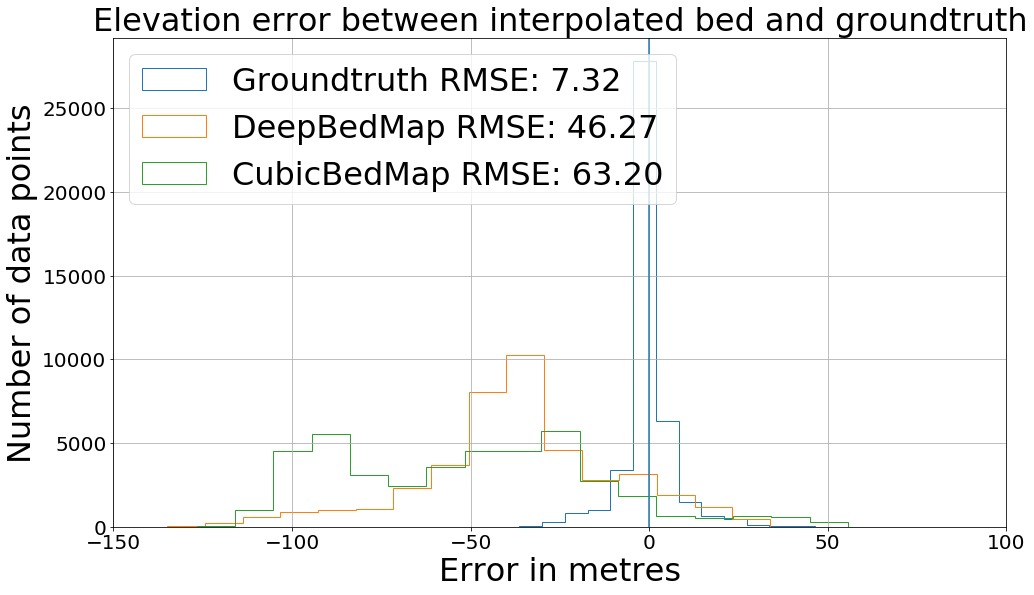

In [27]:
# https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
rmse_groundtruth = (df_groundtruth.error ** 2).mean() ** 0.5
rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5
rmse_cubicbedmap = (df_cubicbedmap.error ** 2).mean() ** 0.5
rmse_synthetichr = (df_synthetichr.error ** 2).mean() ** 0.5
print(f"Difference      : {rmse_deepbedmap3 - rmse_cubicbedmap:.2f}")

bins = 50

fig, ax = plt.subplots(figsize=(16, 9))
# ax.set_yscale(value="symlog")
ax.set_xlim(left=-150, right=100)
df_groundtruth.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"Groundtruth RMSE: {rmse_groundtruth:.2f}",
)
df_deepbedmap3.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"DeepBedMap RMSE: {rmse_deepbedmap3:.2f}",
)
df_cubicbedmap.hist(
    column="error",
    bins=25,
    ax=ax,
    histtype="step",
    label=f"CubicBedMap RMSE: {rmse_cubicbedmap:.2f}",
)
"""
df_synthetichr.hist(
    column="error",
    bins=bins,
    ax=ax,
    histtype="step",
    label=f"SyntheticHR RMSE: {rmse_synthetichr:.2f}",
)
"""

ax.set_title("Elevation error between interpolated bed and groundtruth", fontsize=32)
ax.set_xlabel("Error in metres", fontsize=32)
ax.set_ylabel("Number of data points", fontsize=32)
ax.legend(loc="upper left", fontsize=32)
plt.tick_params(axis="both", labelsize=20)
plt.axvline(x=0)

# plt.savefig(fname="elevation_error_histogram.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [28]:
# https://medium.com/usf-msds/choosing-the-right-metric-for-machine-learning-models-part-1-a99d7d7414e4
rmse_groundtruth = (df_groundtruth.error ** 2).mean() ** 0.5
rmse_deepbedmap3 = (df_deepbedmap3.error ** 2).mean() ** 0.5
rmse_synthetichr = (df_synthetichr.error ** 2).mean() ** 0.5
rmse_cubicbedmap = (df_cubicbedmap.error ** 2).mean() ** 0.5
print(f"Groundtruth RMSE: {rmse_groundtruth}")
print(f"DeepBedMap3 RMSE: {rmse_deepbedmap3}")
print(f"SyntheticHR RMSE: {rmse_synthetichr}")
print(f"CubicBedMap RMSE: {rmse_cubicbedmap}")
print(f"Difference      : {rmse_deepbedmap3 - rmse_cubicbedmap}")

Groundtruth RMSE: 7.318186745825091
DeepBedMap3 RMSE: 46.26644663889489
SyntheticHR RMSE: 159.34174685382456
CubicBedMap RMSE: 63.197682897808036
Difference      : -16.931236258913145


# **DeepBedMap** for the whole of Antarctica

In [30]:
# Bounding Box region in EPSG:3031 covering Antarctica
window_bound_big = rasterio.coords.BoundingBox(
    left=-2_700_000.0, bottom=-2_200_000.0, right=2_800_000.0, top=2_300_000.0
)
print(window_bound_big)

BoundingBox(left=-2700000.0, bottom=-2200000.0, right=2800000.0, top=2300000.0)


Tiling: lowres/bedmap2_bed.tif ... 

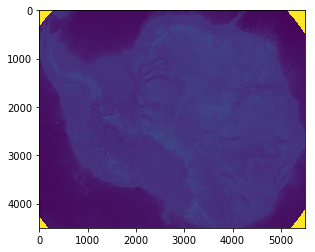

WARN: Tile has missing data, try passing in gapfill_raster_filepath
done!
Tiling: misc/MEaSUREs_IceFlowSpeed_450m.tif ... done!
Tiling: misc/REMA_100m_dem.tif ... done!


In [31]:
X_tile, W1_tile, W2_tile = get_deepbedmap_model_inputs(window_bound=window_bound_big)

In [32]:
# Oh we will definitely need a GPU for this
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
model.to_gpu()

In [33]:
# special zero padding for REMA, 5 pixels on top and bottom, 10 pixels on left and right
W1_tile = np.pad(
    array=W1_tile, pad_width=[(0, 0), (0, 0), (5, 5), (10, 10)], mode="constant"
)

In [34]:
print(X_tile.shape, W1_tile.shape, W2_tile.shape)

(1, 1, 4502, 5502) (1, 1, 45020, 55020) (1, 1, 9004, 11004)


## The whole of Antarctica tiler and predictor!!

Antarctica won't fit into our 16GB of GPU memory, so we have to:

1. Cut a 1000x1000 tile and load the data within this one small tile into GPU memory
2. Use our GPU-enabled model to make a prediction for this tile area
3. Repeat (1) and (2) for every tile we have covering Antarctica

In [35]:
# The whole of Antarctica tile and predictor
if 1 == 1:
    # Size are in kilometres
    final_shape = (18000, 22000)  # 4x that of BEDMAP2
    ary_height, ary_width = (1000, 1000)
    stride_height, stride_width = (1000, 1000)

    Y_hat = np.full(
        shape=(1, final_shape[0] + 20, final_shape[1] + 20),
        fill_value=np.nan,
        dtype=np.float32,
    )

    for y_step in range(0, final_shape[0], stride_height):
        for x_step in range(0, final_shape[1], stride_width):
            # plus 1 pixel on left and right
            x0, x1 = ((x_step // 4), ((x_step + ary_width) // 4) + 2)
            # plus 1 pixel on bottom and top
            y0, y1 = ((y_step // 4), ((y_step + ary_height) // 4) + 2)
            # x0, y0, x1, y1 = (3000,3000,3250,3250)

            X_tile_crop = cupy.asarray(a=X_tile[:, :, y0:y1, x0:x1], dtype="float32")
            W1_tile_crop = cupy.asarray(
                a=W1_tile[:, :, y0 * 10 : y1 * 10, x0 * 10 : x1 * 10], dtype="float32"
            )
            W2_tile_crop = cupy.asarray(
                a=W2_tile[:, :, y0 * 2 : y1 * 2, x0 * 2 : x1 * 2], dtype="float32"
            )

            Y_pred = model.forward(x=X_tile_crop, w1=W1_tile_crop, w2=W2_tile_crop)
            try:
                Y_hat[
                    :, (y0 * 4) + 4 : (y1 * 4) - 4, (x0 * 4) + 4 : (x1 * 4) - 4
                ] = cupy.asnumpy(Y_pred.array[0, :, :, :])
                # print(x0, y0, x1, y1)
            except ValueError:
                raise
            finally:
                X_tile_crop = W1_tile_crop = W2_tile_crop = None

    Y_hat = Y_hat[:, 10:-10, 10:-10]

## Save full map to file

In [36]:
# Save BEDMAP3 to GeoTiff and NetCDF format
# Using int16 instead of float32 to keep things smaller
save_array_to_grid(
    window_bound=window_bound_big,
    array=np.expand_dims(Y_hat.astype(dtype=np.int16), axis=0),
    outfilepath="model/deepbedmap3_big_int16",
    dtype=np.int16,
)

## Show *the* DeepBedMap

In [37]:
with rasterio.open("model/deepbedmap3_big_int16.tif") as raster_tiff:
    deepbedmap_dem = raster_tiff.read(indexes=1, masked=True)

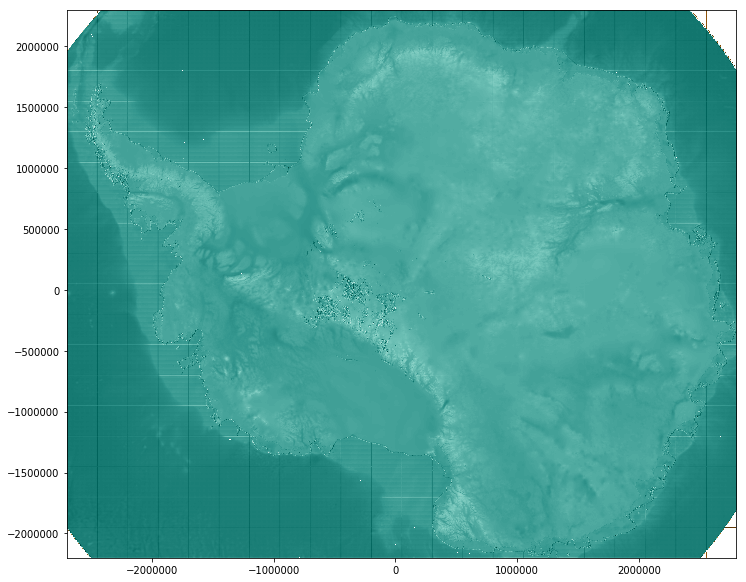

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, squeeze=True, figsize=(12, 12))
rasterio.plot.show(
    source=np.ma.masked_less(x=deepbedmap_dem, value=-10000, copy=False),
    transform=raster_tiff.transform,
    cmap="BrBG_r",
    ax=ax,
)